In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DQLab_reviews(22Sep2022).csv to DQLab_reviews(22Sep2022) (2).csv
Saving DQLab_nieghbourhood(22Sep2022).csv to DQLab_nieghbourhood(22Sep2022) (2).csv
Saving DQLab_listings(22Sep2022) (1).csv to DQLab_listings(22Sep2022) (1) (2).csv


In [ ]:
# A.1 installing package
!pip install pandas
!pip install pandasql
!pip install plotly
!pip install --upgrade 'sqlalchemy<2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import pandasql as ps

import io
import matplotlib.pyplot as plt
import plotly.express as px

import folium
import numpy as np

import seaborn as sns


In [ ]:
date_booked = pd.read_csv(io.BytesIO(uploaded['DQLab_reviews(22Sep2022).csv']))
Airbnb = pd.read_csv(io.BytesIO(uploaded['DQLab_listings(22Sep2022) (1).csv']))
Region = pd.read_csv(io.BytesIO(uploaded['DQLab_nieghbourhood(22Sep2022).csv']))

#**Cleaning**

---



In [ ]:
# drop column 0
date_booked = ps.sqldf("""select listing_id, date
                        from date_booked""")
date_booked.head()

,listing_id,date
0,71609,2018-07-14
1,71609,2019-01-06
2,71609,2019-07-27
3,71609,2019-08-11
4,71609,2019-09-07


In [ ]:
# Buat kolom baru order_month dan order_year
date_booked['order_month']=date_booked['date'].str.slice(0,7)
date_booked['order_year']=date_booked['date'].str.slice(0,4)
date_booked.head()

,listing_id,date,order_month,order_year
0,71609,2018-07-14,2018-07,2018
1,71609,2019-01-06,2019-01,2019
2,71609,2019-07-27,2019-07,2019
3,71609,2019-08-11,2019-08,2019
4,71609,2019-09-07,2019-09,2019


In [ ]:
date_booked_listingid = date_booked.groupby(['listing_id']).size().reset_index(name='counts')
date_booked_listingid

,listing_id,counts
0,71609,10
1,71896,4
2,71903,23
3,275344,5
4,289234,4
...,...,...
2481,712014563808839949,2
2482,712121357550091568,1
2483,712907319520281078,3
2484,713608959415048233,1


In [ ]:
# drop column 0
Airbnb = ps.sqldf("""select id, name, host_id, host_name, neighbourhood, latitude, longitude, room_type, price, minimum_nights, availability_365
                               from Airbnb""")
Airbnb.sort_values(by='id', inplace=True)

# rename column id
Airbnb.rename(columns={"id": "listing_id"}, inplace=True)
Airbnb.head()

,listing_id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365
0,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Bukit Timah,1.33432,103.78521,Private room,80,92,365
1,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340
2,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,Tampines,1.34754,103.95958,Private room,85,92,265
3,71903,Room 2-near Airport & EXPO,367042,Belinda,Tampines,1.34531,103.96100,Private room,85,92,365
4,275344,15 mins to Outram MRT Single Room,1439258,Kay,Bukit Merah,1.28836,103.81144,Private room,49,60,296


In [ ]:
#drop column 0
Region = ps.sqldf("""select neighbourhood_group, neighbourhood
                               from Region """)
Region.head()

,neighbourhood_group,neighbourhood
0,Central Region,Bishan
1,Central Region,Bukit Merah
2,Central Region,Bukit Timah
3,Central Region,Downtown Core
4,Central Region,Geylang


**cleaning outliers pada column harga**


---



<Axes: >

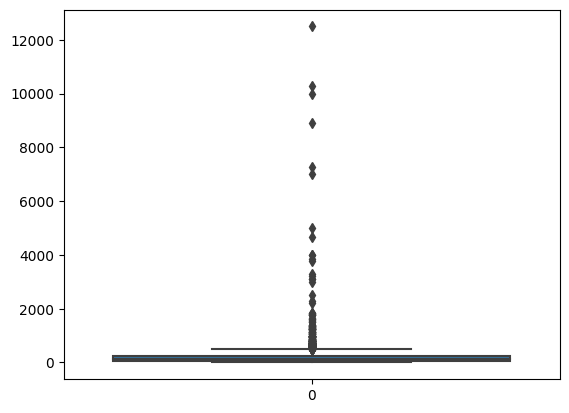

In [ ]:
# cek outliers
sns.boxplot(Airbnb['price'])

In [ ]:
# cleaning pada column price
Q1 = (Airbnb['price']).quantile(0.25)
Q3 = (Airbnb['price']).quantile(0.75)

IQR = Q3-Q1
maks = 1.5*IQR +Q3
min = Q1 - 1.5*IQR

# Filter the DataFrame
Airbnb = Airbnb[(Airbnb['price'] >= min) & (Airbnb['price']<= maks)]

Airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3839 entries, 0 to 4159
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listing_id        3839 non-null   int64  
 1   name              3839 non-null   object 
 2   host_id           3839 non-null   int64  
 3   host_name         3839 non-null   object 
 4   neighbourhood     3839 non-null   object 
 5   latitude          3839 non-null   float64
 6   longitude         3839 non-null   float64
 7   room_type         3839 non-null   object 
 8   price             3839 non-null   int64  
 9   minimum_nights    3839 non-null   int64  
 10  availability_365  3839 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 359.9+ KB


<Axes: >

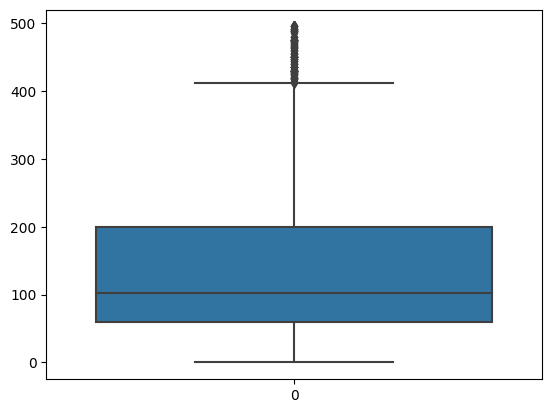

In [ ]:
# cek data setelah dilakukan cleaning
sns.boxplot(Airbnb['price'])

**Merge table**

---



In [ ]:
# date booked new di grouping dengan menghitung jumlah berapa kali listing_id di order
# sehingga tidak dapat digunakan untuk menghitung pada tanggal tertentu
date_booked_new = date_booked.groupby(['listing_id', 'order_month']).size().reset_index(name='counts')
Airbnb_merge1 = pd.merge(date_booked_new, Airbnb, on='listing_id')
Airbnb_merge1 = pd.merge(Airbnb_merge1, Region, on='neighbourhood')
Airbnb_merge1.head()

,listing_id,order_month,counts,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,neighbourhood_group
0,71609,2018-07,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region
1,71609,2019-01,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region
2,71609,2019-07,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region
3,71609,2019-08,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region
4,71609,2019-09,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region


**cleaning region**


---

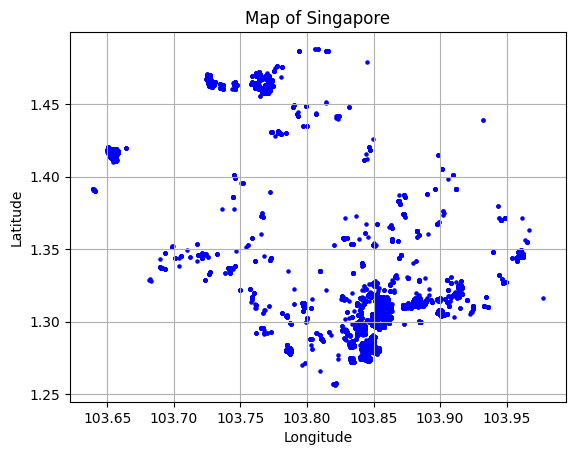

In [ ]:
# Define the bounding box coordinates for Singapore
min_lat = 1.15
max_lat = 1.5
min_lon = 103.6
max_lon = 104.05

# Filter the data points within the bounding box
singapore_data = Airbnb_merge1[(Airbnb_merge1['latitude'] >= min_lat) & (Airbnb_merge1['latitude'] <= max_lat) &
                        (Airbnb_merge1['longitude'] >= min_lon) & (Airbnb_merge1['longitude'] <= max_lon)]

# Plot the filtered data points
plt.scatter(singapore_data['longitude'], singapore_data['latitude'], color='blue', s=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.title('Map of Singapore')
plt.show()

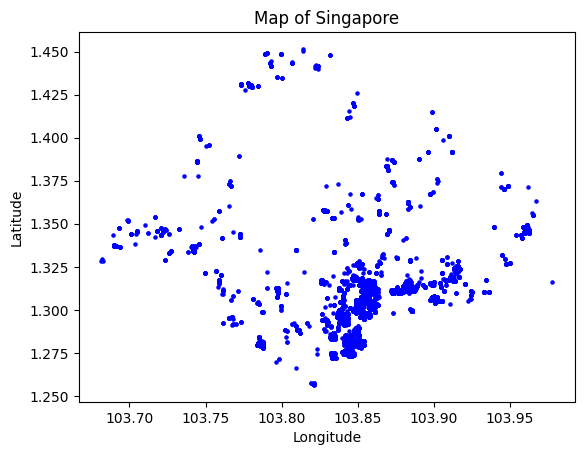

In [ ]:
from shapely.geometry import Point, Polygon

# Define the polygon coordinates for the boundary of Singapore
singapore_polygon = Polygon([
    (1.35, 103.65), (1.40, 103.7), (1.425, 103.75), (1.45, 103.775), (1.465, 103.8),
    (1.45, 103.85), (1.425, 103.90), (1.40, 103.95), (1.35, 104), (1.15, 104), (1.15, 103.65)
])


# Filter data points within the Singapore polygon
Airbnb_merge1['within_singapore'] = Airbnb_merge1.apply(lambda row: singapore_polygon.contains(Point(row['latitude'], row['longitude'])), axis=1)
Airbnb_merge = Airbnb_merge1[Airbnb_merge1['within_singapore']]

# Remove the 'within_singapore' column if desired
Airbnb_merge = Airbnb_merge.drop(columns='within_singapore')

plt.scatter(Airbnb_merge['longitude'], Airbnb_merge['latitude'], color='blue', s=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Singapore')
plt.show()

In [ ]:
Airbnb_merge.head()

,listing_id,order_month,counts,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,neighbourhood_group
0,71609,2018-07,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region
1,71609,2019-01,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region
2,71609,2019-07,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region
3,71609,2019-08,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region
4,71609,2019-09,1,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,Tampines,1.34537,103.95887,Private room,145,92,340,East Region


# Case 0
Peta persebaran

In [ ]:
Airbnb_map = Airbnb_merge.groupby(['neighbourhood_group','neighbourhood', 'latitude', 'longitude'])['listing_id'].count().reset_index()

singapore_map = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

color_dict = {'Central Region': '#D14D72', 'North Region': '#620b75', 'West Region': '#f0dc05', 'East Region': '#0b4485', 'North-East Region': '#016655'}

# Iterate over the hotel data
for index, row in Airbnb_map.iterrows():
    # Create a circle marker for each hotel location
    neighbourhood_group = row['neighbourhood_group']
    color = color_dict.get(neighbourhood_group, 'gray')

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['listing_id']/2,  # Adjust the radius as needed
        color=color,
        fill=True,
        fill_color= color,
        fill_opacity=1
    ).add_to(singapore_map)

# Menampilkan peta
singapore_map

# case 1
Apakah room_type berpengaruh pada ramai atau tidaknya (number of reviews) suatu listing?

In [ ]:
# mengambil column room type Airbnb dan counts(jumlah berapa kali dipesan)
Airbnb_roomtype = Airbnb_merge[['room_type', 'counts']]
Airbnb_roomtype = Airbnb_roomtype.groupby(['room_type'])['counts'].sum().reset_index(name='Total')
Airbnb_roomtype.sort_values(by='Total', ascending=False, inplace=True)
Airbnb_roomtype.head()

,room_type,Total
2,Private room,11921
0,Entire home/apt,7107
1,Hotel room,1703
3,Shared room,720


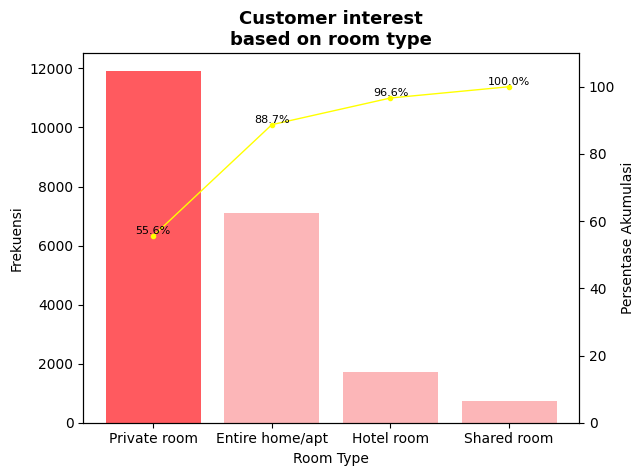

In [ ]:
# Menghitung persentase akumulasi
Airbnb_roomtype['persentase'] = Airbnb_roomtype['Total'].cumsum() / Airbnb_roomtype['Total'].sum() * 100

# Membuat Pareto plot
fig, ax1 = plt.subplots()

# Nilai tertinggi
nilai_tertinggi = Airbnb_roomtype['Total'].max()

# Bar chart
ax1.bar(Airbnb_roomtype['room_type'], Airbnb_roomtype['Total'], color=['#FF5A5F' if x == nilai_tertinggi else '#fcb6b8' for x in Airbnb_roomtype['Total']])
ax1.set_xlabel('Room Type')
ax1.set_ylabel('Frekuensi')
ax1.tick_params(axis='y')

# Garis kumulatif
ax2 = ax1.twinx()
ax2.plot(Airbnb_roomtype['room_type'], Airbnb_roomtype['persentase'], color='yellow', linewidth=1, marker='.')
ax2.set_ylabel('Persentase Akumulasi')
plt.ylim(0, 110)

for i, v in enumerate(Airbnb_roomtype['persentase']):
    ax2.text(i, v, f"{v:.1f}%", ha='center', va='bottom', fontsize=8)

# Menampilkan plot
plt.title('Customer interest\nbased on room type', fontsize=13, fontweight='bold', color='black')
plt.show()

Lebih banyak pelanggan memilih untuk menyewa private, hal ini terlihat dari tabel diatas, dimana terdapat tercatat 11921 transaksi atau sebanyak 55.6% dari total keseluruhan transaksi memilih untuk menyewa Private Room.

'shared room' atau kamar yang digunakan bersamaan dengan customer lain tidak begitu menarik perhatian customer. Hanya terdapat 720 transaksi dilakukan selama tahun 2018-2022.

Beberapa kemungkinan dapat diasumsikan, mengingat:
1. Keamanan yang kurang terjamin
2. Sedang terjadi pandemi, sehingga customer lebih memilih untuk menyewa suatu kamar yang luas atau rumah sepenuhnya.

# Case 2
Pada bulan dan tahun berapa aktivitas penyewaan listing paling sedikit dan paling banyak ?
- group by month
- buat tabel

In [ ]:
Airbnb_bymonth = Airbnb_merge.groupby(['order_month']).size().reset_index(name='counts')
Airbnb_bymonth.head()

,order_month,counts
0,2018-01,176
1,2018-02,173
2,2018-03,160
3,2018-04,171
4,2018-05,165


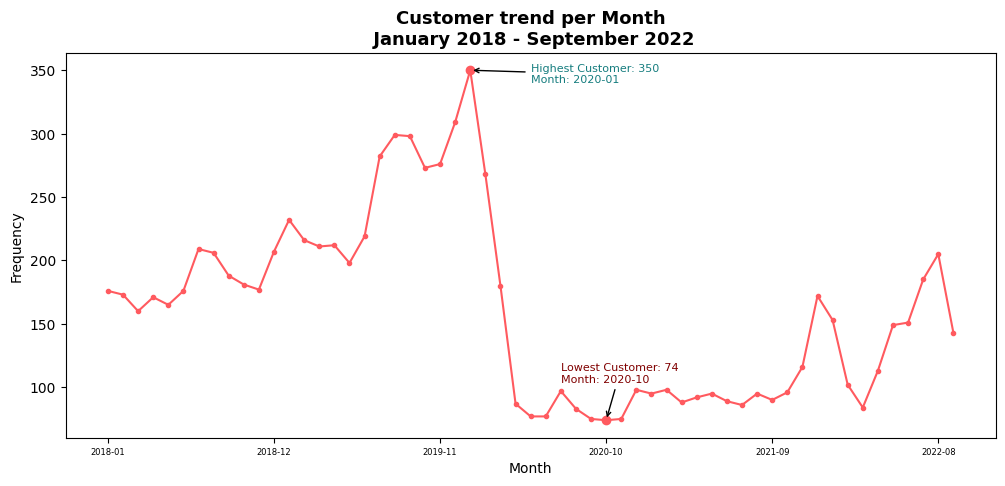

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(Airbnb_bymonth['order_month'], Airbnb_bymonth['counts'], color='#FF5A5F', marker='.')

# Nilai tertinggi
nilai_tertinggi = Airbnb_bymonth['counts'].idxmax()
nilai_terendah = Airbnb_bymonth['counts'].idxmin()

# Ganti warna marker untuk nilai maksimum dan minimum
plt.scatter(Airbnb_bymonth.loc[nilai_tertinggi, 'order_month'], Airbnb_bymonth.loc[nilai_tertinggi, 'counts'], color='#FF5A5F', marker='o')
plt.scatter(Airbnb_bymonth.loc[nilai_terendah, 'order_month'], Airbnb_bymonth.loc[nilai_terendah, 'counts'], color='#FF5A5F', marker='o')

# Memberikan label pada sumbu x dan y
plt.xlabel('Month')
plt.ylabel('Frequency')
#plt.xticks(rotation=90, fontsize=6)

#update xticks
ticks = np.arange(0, len(Airbnb_bymonth['order_month']), len(Airbnb_bymonth['order_month'])//5)
plt.xticks(ticks, Airbnb_bymonth['order_month'][ticks], fontsize=6)

#Annotate
plt.annotate(f"Highest Customer: {Airbnb_bymonth.loc[nilai_tertinggi, 'counts']}\nMonth: {Airbnb_bymonth.loc[nilai_tertinggi, 'order_month']}", xy=(Airbnb_bymonth.loc[nilai_tertinggi, 'order_month'], Airbnb_bymonth.loc[nilai_tertinggi, 'counts']), xytext=('2020-05', Airbnb_bymonth.loc[nilai_tertinggi, 'counts']-10), arrowprops=dict(arrowstyle='->'), fontsize=8, color='#167D7F')
plt.annotate(f"Lowest Customer: {Airbnb_bymonth.loc[nilai_terendah, 'counts']}\nMonth: {Airbnb_bymonth.loc[nilai_terendah, 'order_month']}", xy=(Airbnb_bymonth.loc[nilai_terendah, 'order_month'], Airbnb_bymonth.loc[nilai_terendah, 'counts']), xytext=('2020-07', Airbnb_bymonth.loc[nilai_terendah, 'counts']+30), arrowprops=dict(arrowstyle='->'), fontsize=8, color='#800000')

# Memberikan judul pada grafik
plt.title('Customer trend per Month\n January 2018 - September 2022', fontsize=13, fontweight= 'bold', color='black')

# Menampilkan plot
plt.show()

# tandain paling rendah
# tandain paling tinggi

Dari grafik, terlihat bahwa tren sewa meningkat saat menuju libur akhir tahun 2019 dan 2022, selanjutnya akan terjadi penurunan minat sewa pada awal tahun berikutnya.

Meskipun begitu perlu diteliti kembali, terdapat penurunan yang cukup signifikan pada awal bulan 2020.

**Tren sewa tiap akhir bulan**
[2018-2022]

In [ ]:
# 2018
Airbnb_bymonth_agg1 = Airbnb_bymonth.loc[5:13]
Airbnb_bymonth_agg1.head()

,order_month,counts
5,2018-06,176
6,2018-07,209
7,2018-08,206
8,2018-09,188
9,2018-10,181


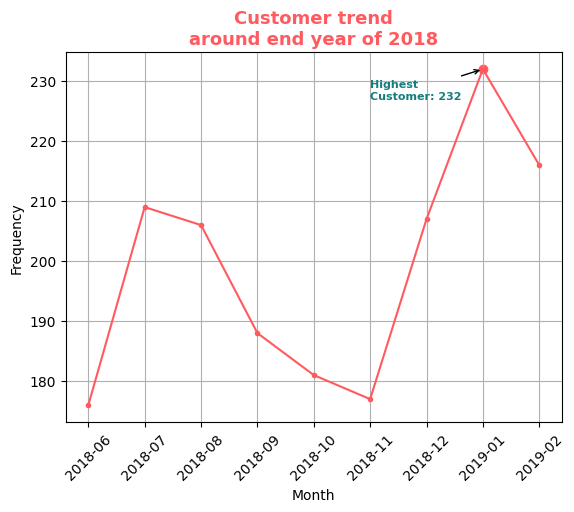

In [ ]:
plt.plot(Airbnb_bymonth_agg1['order_month'], Airbnb_bymonth_agg1['counts'], color='#FF5A5F', marker='.')

# Nilai tertinggi
nilai_tertinggi = Airbnb_bymonth_agg1['counts'].idxmax()
nilai_terendah = Airbnb_bymonth_agg1['counts'].idxmin()

# Ganti warna marker untuk nilai maksimum dan minimum
plt.scatter(Airbnb_bymonth_agg1.loc[nilai_tertinggi, 'order_month'], Airbnb_bymonth_agg1.loc[nilai_tertinggi, 'counts'], color='#FF5A5F', marker='o')
plt.annotate(f"Highest\nCustomer: {Airbnb_bymonth_agg1.loc[nilai_tertinggi, 'counts']}", xy=(Airbnb_bymonth_agg1.loc[nilai_tertinggi, 'order_month'], Airbnb_bymonth_agg1.loc[nilai_tertinggi, 'counts']), xytext=('2018-11', Airbnb_bymonth_agg1.loc[nilai_tertinggi, 'counts']-5), arrowprops=dict(arrowstyle='->'), fontsize=8, fontweight ='bold', color='#167D7F')

# Memberikan label pada sumbu x dan y
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Memberikan judul pada grafik
plt.title('Customer trend\naround end year of 2018',fontsize=13, fontweight='bold', color='#FF5A5F')

# Menampilkan grid pada grafik
plt.grid(True)

# Menampilkan plot
plt.show()

In [ ]:
# 2019
Airbnb_bymonth_agg2= Airbnb_bymonth.loc[17:25]
Airbnb_bymonth_agg2.head()

,order_month,counts
17,2019-06,219
18,2019-07,282
19,2019-08,299
20,2019-09,298
21,2019-10,273


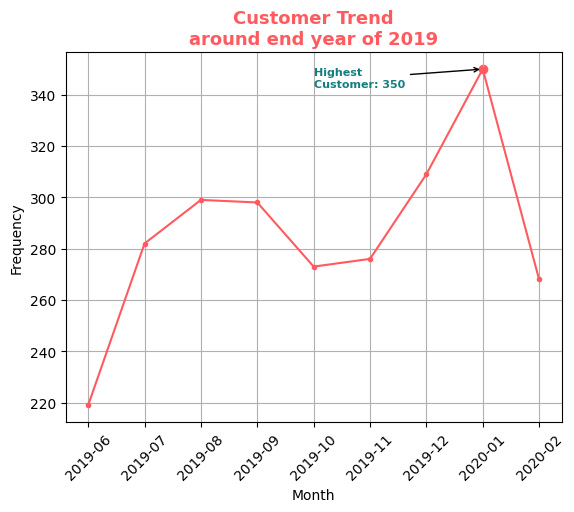

In [ ]:
plt.plot(Airbnb_bymonth_agg2['order_month'], Airbnb_bymonth_agg2['counts'], color='#FF5A5F', marker='.')

# Nilai tertinggi
nilai_tertinggi = Airbnb_bymonth_agg2['counts'].idxmax()
nilai_terendah = Airbnb_bymonth_agg2['counts'].idxmin()

# Ganti warna marker untuk nilai maksimum dan minimum
plt.scatter(Airbnb_bymonth_agg2.loc[nilai_tertinggi, 'order_month'], Airbnb_bymonth_agg2.loc[nilai_tertinggi, 'counts'], color='#FF5A5F', marker='o')
plt.annotate(f"Highest\nCustomer: {Airbnb_bymonth_agg2.loc[nilai_tertinggi, 'counts']}", xy=(Airbnb_bymonth_agg2.loc[nilai_tertinggi, 'order_month'], Airbnb_bymonth_agg2.loc[nilai_tertinggi, 'counts']), xytext=('2019-10', Airbnb_bymonth_agg2.loc[nilai_tertinggi, 'counts']-7), arrowprops=dict(arrowstyle='->'), fontsize=8, fontweight ='bold', color='#167D7F')

# Memberikan label pada sumbu x dan y
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Memberikan judul pada grafik
plt.title('Customer Trend\naround end year of 2019', fontsize=13, fontweight='bold', color='#FF5A5F')

# Menampilkan grid pada grafik
plt.grid(True)

# Menampilkan plot
plt.show()

**Nilai turun maksimal**

In [ ]:
# 2018
Airbnb_bymonth_agg3 = Airbnb_bymonth.loc[20:33]
Airbnb_bymonth_agg3.head()

,order_month,counts
20,2019-09,298
21,2019-10,273
22,2019-11,276
23,2019-12,309
24,2020-01,350


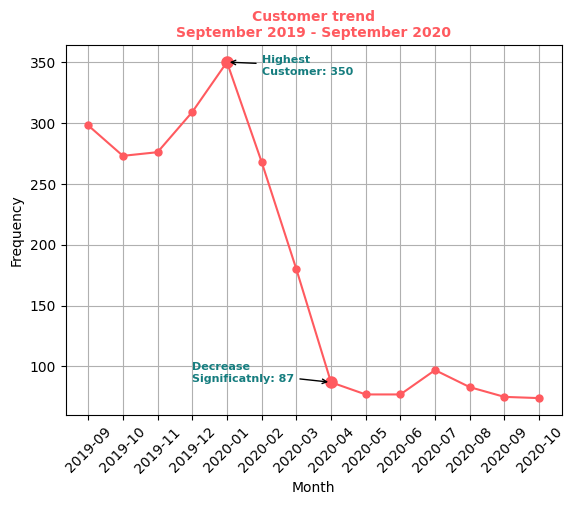

In [ ]:
# Nilai tertinggi
exact_x = '2020-04'
max_y = Airbnb_bymonth_agg3['counts'].max()

plt.plot(Airbnb_bymonth_agg3['order_month'], Airbnb_bymonth_agg3['counts'], color='#FF5A5F', marker='.')

for i, row in Airbnb_bymonth_agg3.iterrows():
    x_val = row['order_month']
    y_val = row['counts']

    # Customize the marker for the exact value on the x-axis
    if x_val == exact_x:
        plt.plot(x_val, y_val, marker='o', markersize=8, color='#FF5A5F')
        # Annotate the exact value
        plt.annotate(f'Decrease\nSignificatnly: {y_val}', (x_val, y_val), xytext=('2019-12', y_val + 0.5), arrowprops=dict(arrowstyle='->'), fontsize=8, fontweight ='bold', color='#167D7F')

    # Customize the marker for the maximum value
    elif y_val == max_y:
        plt.plot(x_val, y_val, marker='o', markersize=8, color='#FF5A5F')
        # Annotate the maximum value
        plt.annotate(f'Highest\nCustomer: {y_val}', (x_val, y_val), xytext=('2020-02', y_val - 10), arrowprops=dict(arrowstyle='->'), fontsize=8, fontweight ='bold', color='#167D7F')

    else:
        plt.plot(x_val, y_val, marker='o', markersize=5, color='#FF5A5F')

# Memberikan label pada sumbu x dan y
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Memberikan judul pada grafik
plt.title('Customer trend\nSeptember 2019 - September 2020',fontsize=10, fontweight='bold', color='#FF5A5F')

# Menampilkan grid pada grafik
plt.grid(True)

# Menampilkan plot
plt.show()

# Case 3
Menghitung region dengan tren tertinggi


In [ ]:
Airbnb_merge['revenue']=Airbnb_merge['counts']*Airbnb_merge['price']
Airbnb_neighbourhood_group = Airbnb_merge.groupby(['order_month', 'neighbourhood_group'])['revenue'].sum().reset_index()
Airbnb_neighbourhood_group.head()

,order_month,neighbourhood_group,revenue
0,2018-01,Central Region,32110
1,2018-01,East Region,5218
2,2018-01,North Region,945
3,2018-01,North-East Region,1710
4,2018-01,West Region,1563


In [ ]:
# create plot
fig_line = px.line(Airbnb_neighbourhood_group,x="order_month",y="revenue",color="neighbourhood_group",template="simple_white",color_discrete_sequence=["#D14D72","#B2BEB5","#B2BEB5","#B2BEB5","#B2BEB5"], markers=True)

#Modify Title
fig_line.update_layout(title="<b>Total revenue by neighbourhood in 4 years</b>", title_font=dict(size=20,family="arial"))

#Update X & Y Labels
fig_line.update_xaxes(title="<b>Order Year</b>",title_font=dict(size=13,family="arial"))
fig_line.update_yaxes(title="<b>Total Revenue(Rp)</b>",title_font=dict(size=13,family="arial"))

# Update Line & Markers
fig_line.update_traces(line=dict(width=2),marker=dict(size=4))

# Show Plot
fig_line.show()

Terlihat bahwa **Central Region** merupakan wilayah yang menghasilkan paling banyak keuntungan.

Dapat diasumsikan beberapa kemungkinan :
1. Banyaknya unit pada region tersebut
2. Banyaknya customer
3. Lokasi strategis (pariwisata)

# case 4
Selanjutnya akan dihitung, jumlah unit pada masing-masing region


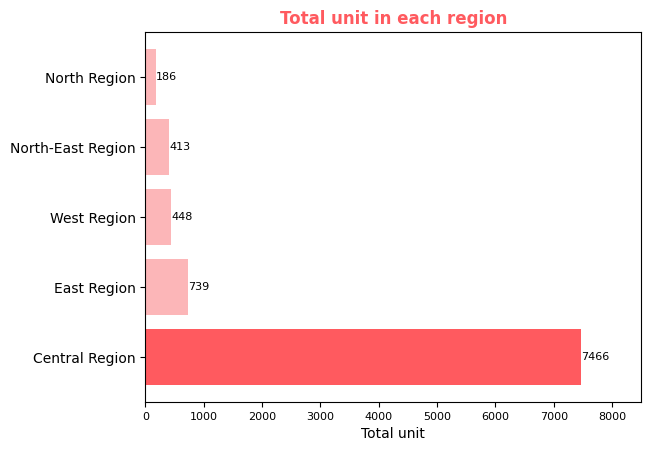

In [ ]:
Airbnb_listingid = Airbnb_merge.groupby(['neighbourhood_group'])['listing_id'].size().reset_index()
Airbnb_listingid.sort_values(by='listing_id', ascending=False, inplace=True)

nilai_tertinggi=Airbnb_listingid['listing_id'].max()

plt.barh(Airbnb_listingid['neighbourhood_group'],Airbnb_listingid['listing_id'], color=['#FF5A5F' if x == nilai_tertinggi else '#fcb6b8' for x in Airbnb_listingid['listing_id']])

for i, v in enumerate(Airbnb_listingid['listing_id']):
    plt.text(v + 0.5, i, str(v), color='black', fontsize=8, va='center')

plt.title('Total unit in each region', fontsize=12, color='#FF5A5F', fontweight='bold')
plt.xlabel('Total unit')

plt.xticks(fontsize=8)
plt.xlim(0, 8500)

plt.show()

Terlihat bahwa **Central Region** memiliki **jumlah penginapan** yang lebih banyak diregion lain, dapat diasumsikan bahwa banyaknya jumlah unit berbanding lurus dengan jumlah profit yang dihasilkan pada masing-masing region

# case 5
Selanjutnya akan diperiksa rata-rata harga pada masing-masing region

In [ ]:
# grouping berdasarkan mean harga pada masing masing reg
Airbnb_price = Airbnb_merge.groupby(['order_month', 'neighbourhood_group'])['price'].mean().reset_index()
Airbnb_price.head()

,order_month,neighbourhood_group,price
0,2018-01,Central Region,112.285714
1,2018-01,East Region,113.470588
2,2018-01,North Region,167.500000
3,2018-01,North-East Region,90.750000
4,2018-01,West Region,113.571429


In [ ]:
# create plot
fig_line = px.line(Airbnb_price,x="order_month",y="price",color="neighbourhood_group",template="simple_white",color_discrete_sequence=["#D14D72","#B2BEB5","#B2BEB5","#B2BEB5","#B2BEB5"], markers=True)

#Modify Title
fig_line.update_layout(title="<b>The mean price of each neighbourhood in 4 years</b>", title_font=dict(size=20,family="arial", color='#D14D72'))

#Update X & Y Labels
fig_line.update_xaxes(title="<b>Order Year</b>",title_font=dict(size=13,family="arial"))
fig_line.update_yaxes(title="<b>Mean price(Rp)</b>",title_font=dict(size=13,family="arial"))

# Update Line & Markers
fig_line.update_traces(line=dict(width=2),marker=dict(size=4))

# Show Plot
fig_line.show()

Terdapat fakta menarik pada grafik diatas, rata-rata harga pada central region cenderung lebih tinggi dibanding region lainnya.

Namun, yang menjadi menarik adalah harga rata-rata pada north region adalah yang paling rendah dibanding yang lainnya.

In [ ]:
# grouping berdasarkan mean harga pada masing masing reg
Airbnb_price1 = Airbnb_merge.groupby(['neighbourhood_group'])['price'].mean().sort_values().reset_index()
Airbnb_price1

,neighbourhood_group,price
0,North-East Region,84.910412
1,West Region,90.180804
2,North Region,103.166667
3,East Region,116.144790
4,Central Region,146.432762


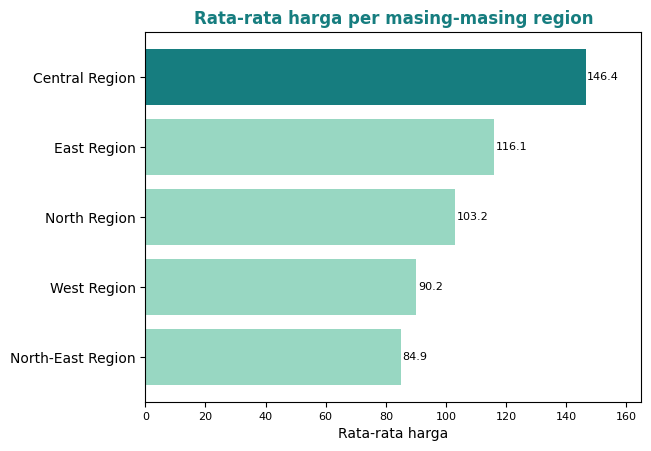

In [ ]:
nilai_maks=Airbnb_price1['price'].max()

plt.barh(Airbnb_price1['neighbourhood_group'],Airbnb_price1['price'], color=['#167D7F' if x == nilai_maks else '#98D7C2' for x in Airbnb_price1['price']])

for i, v in enumerate(Airbnb_price1['price']):
    plt.text(v + 0.5, i, str(f"{v:.1f}"), color='black', fontsize=8, va='center')

plt.title('Rata-rata harga per masing-masing region', fontsize=12, color='#167D7F', fontweight='bold')
plt.xlabel('Rata-rata harga')

plt.xticks(fontsize=8)
plt.xlim(0,165)

plt.show()

# case 6
Selanjutnya akan dibuat grafik tren customer per region

In [ ]:
# grouping berdasarkan jumlah customer pada masing masing region
Airbnb_cust = Airbnb_merge.groupby(['neighbourhood_group'])['counts'].sum().sort_values().reset_index()
Airbnb_cust

,neighbourhood_group,counts
0,North Region,276
1,West Region,651
2,North-East Region,1007
3,East Region,1994
4,Central Region,17523


In [ ]:
# grouping berdasarkan jumlah customer pada masing masing region
Airbnb_cust1 = Airbnb_merge.groupby(['order_month','neighbourhood_group'])['counts'].sum().reset_index()
Airbnb_cust1.sort_values(by='order_month', inplace=True)
Airbnb_cust1.head()

,order_month,neighbourhood_group,counts
0,2018-01,Central Region,300
1,2018-01,East Region,55
2,2018-01,North Region,5
3,2018-01,North-East Region,16
4,2018-01,West Region,13


In [ ]:
# create plot
fig_line = px.line(Airbnb_cust1,x="order_month",y="counts",color="neighbourhood_group",template="simple_white", color_discrete_sequence=["#D14D72","#B2BEB5","#B2BEB5","#B2BEB5","#B2BEB5"], markers=True)

#Modify Title
fig_line.update_layout(title="<b>Customer by region in 4 years</b>", title_font=dict(size=20,family="arial", color='#167D7F'))

#Update X & Y Labels
fig_line.update_xaxes(title="<b>Years</b>",title_font=dict(size=13,family="arial"))
fig_line.update_yaxes(title="<b>Customers</b>",title_font=dict(size=13,family="arial"))

# Update Line & Markers
fig_line.update_traces(line=dict(width=2),marker=dict(size=4))

# Show Plot
fig_line.show()

Dari data-data diatas dapat dibuat beberapa kesimpulan, yaitu
1. Harga pada central region tidak jauh berbeda dengan rata-rata harga pada region lain
2. Central region merupakan wilayah favorit para customer

# case 7
Akan ditelusuri lokasi terbaik untuk **central region**
1. 3 Lokasi yang memiliki customer paling tinggi di masing-masing region
2. Hitung rata-rata harga dan revenue pada 5 lokasi tersebut
3. Jenis room type yang paling laku


In [ ]:
Airbnb_counts = Airbnb_merge.groupby(['neighbourhood','neighbourhood_group'])['listing_id'].count().reset_index(name='counts')
Airbnb_counts.sort_values(by=['neighbourhood_group','counts'], ascending=False, inplace=True)
Airbnb_counts = Airbnb_counts.groupby('neighbourhood_group').apply(lambda x: x.nlargest(3, ['counts'])).reset_index(drop=True)
Airbnb_counts.head(15)

,neighbourhood,neighbourhood_group,counts
0,Kallang,Central Region,1411
1,Outram,Central Region,1051
2,Rochor,Central Region,1002
3,Bedok,East Region,441
4,Tampines,East Region,205
5,Pasir Ris,East Region,93
6,Woodlands,North Region,152
7,Yishun,North Region,18
8,Sembawang,North Region,14
9,Serangoon,North-East Region,220


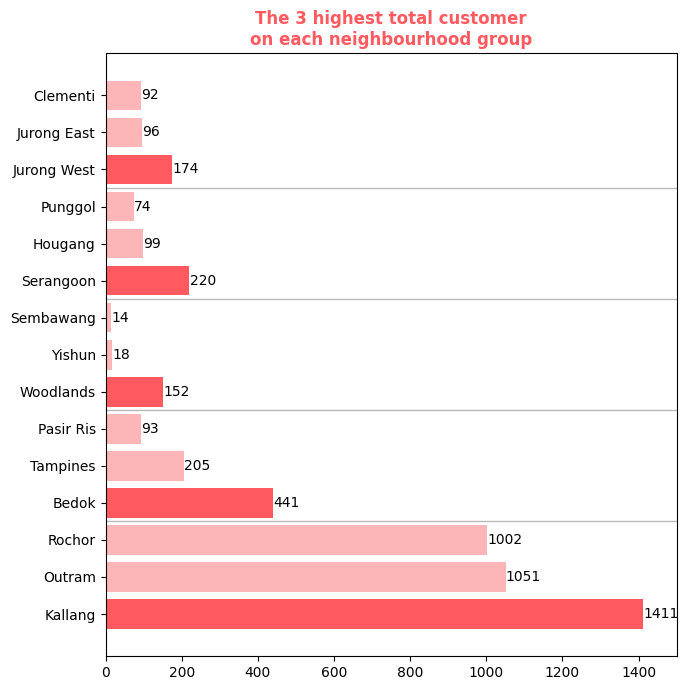

In [ ]:
sorted_counts = Airbnb_counts.head(15)

plt.figure(figsize=(7,7))

# Group the data by 'Group' and find the maximum value in each group
max_grouped = sorted_counts.groupby('neighbourhood_group')['counts'].max()

# Plot the bar chart
plt.barh(sorted_counts['neighbourhood'], sorted_counts['counts'], color='#fcb6b8')
plt.title('The 3 highest total customer\non each neighbourhood group', color='#FF5A5F', fontweight='bold')
# line between the region
plt.axhline(y=2.5, color='#bababa', linewidth=1)
plt.axhline(y=5.5, color='#bababa', linewidth=1)
plt.axhline(y=8.5, color='#bababa', linewidth=1)
plt.axhline(y=11.5, color='#bababa', linewidth=1)

plt.xlim(0,1500)

#'#FF5A5F' '#fcb6b8'
for i, v in enumerate(sorted_counts['counts']):
    plt.text(v + 0.5, i, str(v), color='black', va='center')

# Highlight the bars with the maximum value in each group
for index, value in max_grouped.items():
    max_index = sorted_counts[(sorted_counts['neighbourhood_group'] == index) & (sorted_counts['counts'] == value)].index
    plt.barh(max_index, sorted_counts.loc[max_index]['counts'], color='#FF5A5F')

plt.tight_layout()
plt.show()

Terlihat bahwa mayoritas customer memilih woodlands sebagai destinasi utama, angka yang cukup signifikan jika dibandingkan dengan kota-kota lain.

# case 8
Cari frekuensi harga yang paling diorder muncul pada 5 lokasi tersebut

In [ ]:
Airbnb_north = Airbnb_merge.loc[Airbnb_merge['neighbourhood_group'] == 'Central Region']

Airbnb_north.head()

,listing_id,order_month,counts,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,neighbourhood_group,revenue
205,275344,2018-09,1,15 mins to Outram MRT Single Room,1439258,Kay,Bukit Merah,1.28836,103.81144,Private room,49,60,296,Central Region,49
206,275344,2019-11,1,15 mins to Outram MRT Single Room,1439258,Kay,Bukit Merah,1.28836,103.81144,Private room,49,60,296,Central Region,49
207,275344,2020-04,1,15 mins to Outram MRT Single Room,1439258,Kay,Bukit Merah,1.28836,103.81144,Private room,49,60,296,Central Region,49
208,275344,2020-12,1,15 mins to Outram MRT Single Room,1439258,Kay,Bukit Merah,1.28836,103.81144,Private room,49,60,296,Central Region,49
209,275344,2022-07,1,15 mins to Outram MRT Single Room,1439258,Kay,Bukit Merah,1.28836,103.81144,Private room,49,60,296,Central Region,49


In [ ]:
Airbnb_north = Airbnb_merge.loc[Airbnb_merge['neighbourhood'] == 'Kallang']
Airbnb_north_price = Airbnb_north.groupby(['price'])['counts'].sum().reset_index(name='freq')
Airbnb_north_price.sort_values(by='price', ascending=True, inplace=True)
Airbnb_north_price

,price,freq
0,22,39
1,24,104
2,25,3
3,26,2
4,27,140
...,...,...
83,288,2
84,298,1
85,300,5
86,424,1


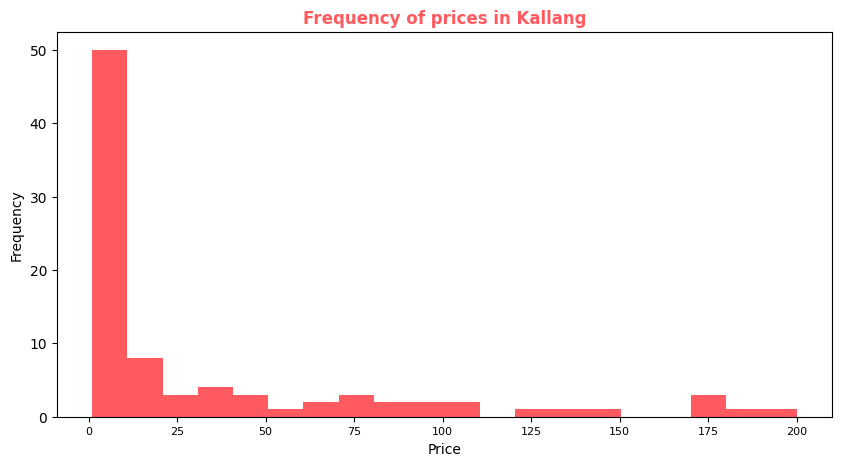

In [ ]:
plt.figure(figsize=(10,5))
nilai_tertinggi=Airbnb_north_price['freq'].max()
#['#FF5A5F' if x == nilai_tertinggi else '#fcb6b8' for x in Airbnb_north_price['freq']])
plt.hist(Airbnb_north_price['freq'], bins=20, color= '#FF5A5F')

#for i, v in enumerate(Airbnb_north_price['freq']):
 #   plt.text(v + 0.5, i, str(v), color='black', fontsize=8, va='center')

plt.title('Frequency of prices in Kallang', fontsize=12, color='#FF5A5F', fontweight='bold')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.xticks(fontsize=8)

plt.show()


In [ ]:
Airbnb_north2 = Airbnb_merge.loc[Airbnb_merge['neighbourhood'] == 'Kallang']
Airbnb_north_roomtype = Airbnb_north2.groupby(['room_type'])['counts'].sum().sort_values().reset_index(name='unit')
Airbnb_north_roomtype

,room_type,unit
0,Shared room,278
1,Hotel room,432
2,Entire home/apt,714
3,Private room,1543


In [ ]:
# Create plot
fig = px.pie(Airbnb_north_roomtype,values="unit",color="room_type", names="room_type",color_discrete_sequence=["#b5bcf7","#e68efa","#eb71ba","#D14D72"], hole=0.6)

#Modify Title
fig.update_layout(title="<b>Customer interest<br>based on type of room</b>", title_font=dict(color='navy',size=20,family="arial"),title_x=0.5, width=600)

# Update traces
fig.update_traces(textposition="outside", textfont=dict(color="black", size=10),textinfo="label+percent",pull=[0,0,0,0], rotation = 220)

# add Annotation
fig.add_annotation(text="<b>52% Customers<br>choose private room</b>",showarrow=False, font=dict(color='navy',size=17))

# Show Plot
fig.show()